## 多项式回归

In [1]:
%matplotlib inline
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20
n_train,n_test = 100,100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features = np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1)
    
labels = np.dot(poly_features,true_w)
labels += np.random.normal(scale=0.1,size=labels.shape)

In [3]:
true_w,features,poly_features,labels = [torch.tensor(x,dtype=torch.float32) for x in [true_w,features,poly_features,labels]]
features[:2],poly_features[:2,:],labels[:2]

(tensor([[-1.0695],
         [-0.1507]]),
 tensor([[ 1.0000e+00, -1.0695e+00,  5.7188e-01, -2.0387e-01,  5.4508e-02,
          -1.1659e-02,  2.0782e-03, -3.1750e-04,  4.2445e-05, -5.0438e-06,
           5.3941e-07, -5.2444e-08,  4.6740e-09, -3.8451e-10,  2.9373e-11,
          -2.0942e-12,  1.3998e-13, -8.8064e-15,  5.2323e-16, -2.9451e-17],
         [ 1.0000e+00, -1.5073e-01,  1.1360e-02, -5.7079e-04,  2.1509e-05,
          -6.4843e-07,  1.6290e-08, -3.5078e-10,  6.6092e-12, -1.1069e-13,
           1.6685e-15, -2.2863e-17,  2.8719e-19, -3.3299e-21,  3.5852e-23,
          -3.6027e-25,  3.3940e-27, -3.0094e-29,  2.5201e-31, -1.9992e-33]]),
 tensor([0.5882, 4.4586]))

In [4]:
def evaluate_loss(net,data_iter,loss):  #@save
    metric = d2l.Accumulator(2)
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 正常

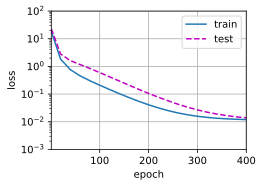

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### 欠拟合

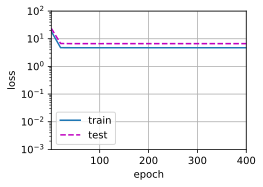

In [7]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### 过拟合

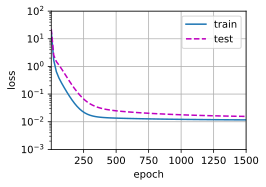

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)